# Model image results to extract information
We might need this if the observation contains bright and faint components.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.signal
import scipy.optimize

from pandeia_funcs import *
import pandeia_coronagraphy as pandeia_c

import alma.image

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# extract and organise the results
with open('pandeia-results.pkl','rb') as f:
    results = pickle.load(f)

nimg = len(results) // 3
target_results = results[:nimg]
star_results = results[nimg:2*nimg]
ref_results = results[2*nimg:]

# extract some relevant images
target_slope = []
target_snr = []
target_sat = []
star_slope = []
star_snr = []
star_sat = []
ref_slope = []
ref_snr = []
ref_sat = []
for t, s, r in zip(target_results, star_results, ref_results):
    target_slope.append(t['2d']['detector'])
    target_snr.append(t['2d']['snr'])
    target_sat.append(t['2d']['saturation'])
    star_slope.append(s['2d']['detector'])
    star_snr.append(s['2d']['snr'])
    star_sat.append(s['2d']['saturation'])
    ref_slope.append(r['2d']['detector'])
    ref_snr.append(r['2d']['snr'])
    ref_sat.append(r['2d']['saturation'])

In [3]:
# decide which set of images we want to model
i = 3
filt = target_results[i]['input']['configuration']['instrument']['filter']
wave = int(filt[1:-1]) / 100

# grab the images and subtract background
noise = np.sqrt(np.percentile(target_slope[i], 30))
image = target_slope[i] - np.percentile(target_slope[i], 30)
star = star_slope[i] - np.percentile(star_slope[i], 30)
psf = ref_slope[i] - np.percentile(ref_slope[i], 30)
psf /= np.sum(psf)

bg = np.percentile(image, 30)
print(noise, bg)

(57.83314026244435, 0.0)


In [4]:
# get an image model instance
ii = alma.image.Image(image_size=image.shape, arcsec_pix=0.11, dens_model='gauss_2d',
                      wavelength=wave, no_primary_beam=True)

model:los_image_axisym with density:gauss_2d and emit:blackbody
parameters are ['$x_0$', '$y_0$', '$\\Omega$', '$i$', '$F$', '$r_0$', '$\\sigma_r$']
rmax not set, run compute_rmax before generating images


In [5]:
# some functions for making synthetic images and minimising
def make_img(par):
    disk = ii.image_full(par[:-4])
    # add star at center
    cen = (np.array(disk.shape)-1)/2
    star = np.zeros(disk.shape)
    star[cen[1],cen[0]] = par[-2]
    disk += pandeia_c.transformations.fourier_imshift(star, par[-4], par[-3])
    return disk

def conv_img(par, psf):
    img = make_img(par)
    conv = scipy.signal.convolve2d(img, psf, mode='same')
    # and background
    conv += par[-1]
    return conv
    
def lnlike(par, img, noise, psf):
    sim = conv_img(par, psf)
    res = sim - img
    return -np.sum((res/noise)**2)/2

def nlnlike(par, img, noise, psf):
    return -lnlike(par, img, noise, psf)

In [6]:
# guess some parameters for the model (we know these from create-scene...)
par = [0.05, 0.05, -30, 70, 3.8e5, 1.15, 0.14, 0.012, -0.08, 1.e6, 0.0]

ii.compute_rmax(par, tol=1e-2, expand=5, image_full=True)
lnlike(par, image, noise, psf)

radial r_max: 19 pix
model x,y,z extent 9, 12, 13


-4089.4234279936995

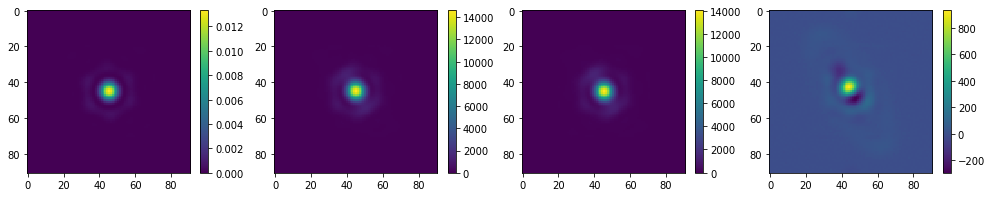

In [7]:
# an indication of whether the first guess is OK
show_images([psf, image, conv_img(par, psf), image - conv_img(par, psf)])

In [8]:
# minimise
res = scipy.optimize.minimize(nlnlike, par, args=(image, noise, psf),
                              method='bfgs', options={'maxiter':1000})

('Desired error not necessarily achieved due to precision loss.', 126.15669112497665)
[ 4.18963973e-01  4.14705189e-01 -3.01476771e+01  6.92319757e+01
  3.99701977e+05  1.08900806e+00  2.11020297e-01 -8.06441364e-02
  8.87964308e-02  1.03158003e+06  2.23265251e+00]
126.15669112497665


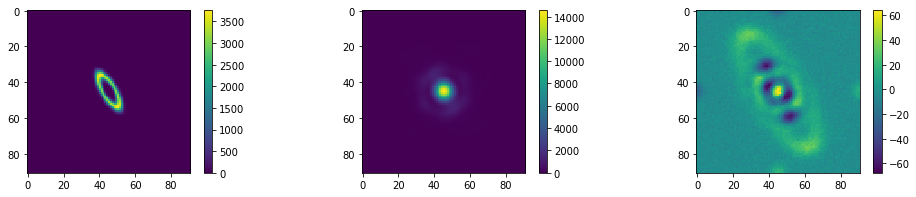

In [9]:
# and see what we recovered
print(res['message'],res['fun'])
out = res['x']
print(out)
print(nlnlike(out, image, noise, psf))

show_images([ii.image_full(out[:-2]), conv_img(out, psf), image - conv_img(out, psf)])